#### Sustainable Economic Growth Model
J M Applegate, Taylor Quinn   
8 March, 2021

In [5]:
%load_ext rpy2.ipython
import numpy as np
import pandas as pd
from scipy.integrate import odeint
from random import seed, gauss, randint
import csv
import random
seed(1)

In [11]:
%%R 
library(tidyverse)
library(ggthemes)
palette_ordered <- c('darkred', 'deepskyblue2', 'paleturquoise3', 'red3', 
                    'steelblue3', 'lightpink2', 'darkslategrey', 'cadetblue', 
                    'royalblue3', 'darkorange', 'palegreen3', 'navajowhite3')

### Sustainable Economic Growth Model (SEG)
Starting with a small settlement which harvests some natural resource which is exported, thus earning imports.  
Two fundamental processes are import replacement and export expansion.  
Exports, $E$, equals imports, $I$. Total size of the economy is measured as size of consumption, $C$, and production, $P$, therefore $P + C$.
#### Import Replacement
Imports from $I$ flow to $P$ or $C$ proportionately.  
Imports are replaced at a rate $\rho$, where $\rho = (\rho_C + \rho_P) < 1$.  
$\rho$ is related to an economy's *dynamism*, involving untapped purchasing power, knowledge, diversity and inventiveness.  
If $\rho = 1$ then all imports are replaced each timestep, which is unrealistic.  
$\rho$ could also be modeled stochastically.    
Each timestep $\rho I$ imports are replaced and proportionately divided between $C$ and $P$, thus 
\begin{align}
\frac{dC}{dt} &= \rho I\frac{C}{C + P}\\
\frac{dP}{dt} &= \rho I\frac{P}{C + P}.\\
\end{align}

*What expansion is being measured? Capacity? Past timestep quantitative flows?*  

$\rho I = X$, and increases in $C$ and $P$ are measured in $X$.  
$X$ is a function of numerous quantitative and qualitative aspects of an economy, just as $\rho.$      
If an economy was importing jam and decides to produce jam locally, then the economy still needs to import the components of jam (berries, sugar, pectin, jars).  
Jam is therefore berries, sugar, pectin and jars plus some industrious addition, $X$.  
This $X$, the value-add of jam production, is no longer imported, and $X$ is the quantity that translates to new imports.  
Note that $I$ and $E$ remain constant, but that $C$ and $P$, the settlements economic activity, increases.  
Both consumption and production imports can be novel, thus diversity in both consumption and production increase each timestep.

*How does economic diversity, $\delta = \delta_C + \delta_P$, increase? How does $\rho$ increase?*  

$\delta$ increases as a function of the increases in $C, P$ and a parameter $\gamma$ where $0 < \gamma < 1$ and $0 < \delta < \infty:$ as
\begin{equation}
\frac{d\delta}{dt} = \gamma  \rho  I.
\end{equation}

$\rho$ will increase with $\delta$ but has an upper limit less than 1, so perhaps model as a scaled logistic function.  
For now, $\rho$ is constant.

In [7]:
# Initial conditions
C = 10
P = 20
I = 8
E = I

delta = 5
rho = .4
nu = .2
gamma = .1
steps = 20
alpha = 1.1
beta = 1.5

results = []
t = 1

while t <= steps:
    dCdt = rho * I * (C / (C + P))
    dPdt = rho * I * (P / (C + P))
    C += dCdt
    P += dPdt
    delta += gamma * rho * I
    
    day_results = {
        't': t,
        #'I': I,
        'E': E,
        'C': C,
        'P': P,
        'dCdt': dCdt,
        'dPdt': dPdt,
        'delta': delta,
        'rho': rho,
        'nu': nu,
    }
    results.append(day_results)
    t += 1 
df = pd.DataFrame(results)

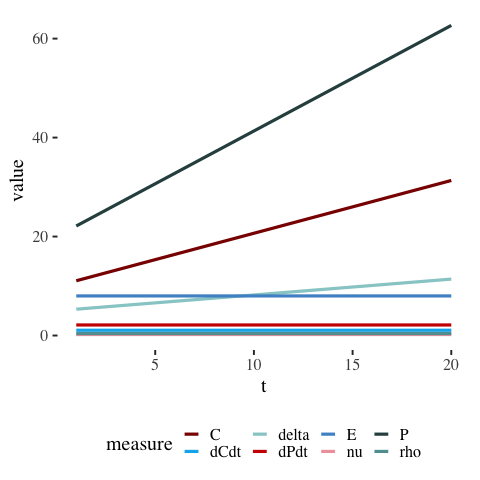

In [8]:
%%R -i df
plot.data <- df %>% gather(measure, value, -t) #%>% 
    #mutate(category = ifelse(measure %in% c('E', 'C', 'P'), 'box', 
                             #ifelse(measure %in% c('dEdt', 'dCdt', 'dPdt'), 'changes', 'parameters')))
ggplot(plot.data, aes(x = t, y = value, color = measure)) + theme_tufte(base_size = 20) + 
    geom_line(size = 1.5) + 
    #facet_wrap(~ category) +
    scale_color_manual(values = palette_ordered) +
    theme(legend.position = 'bottom')

#### Export Expansion
Whenever there is an increase in production imports,
\begin{equation}
\frac{dP}{dt} > 0,
\end{equation}
production activity increases in one of two ways; either intensive, more of the same, or extensive, something innovative is produced.  
An intensive increase does not increase $\delta_P$ but an extensive increase does.  
The new imports are modified by a factor $\nu = (\nu_i + \nu_e) < 1$ for intensive and extensive processes.  
$\nu,$ like $\rho,$ is a function of diversity, untapped purchasing power, knowledge and inventiveness.

The increase in exports is 
\begin{equation}
\frac{dE}{dt} = \nu\left(\frac{dP}{dt}\right)_{t-1}
\end{equation}
which is translates to an increase in imports, which in turn is divided proportionatly between $C$ and $P$, thus
\begin{align}
\frac{dC}{dt} &= \frac{dE}{dt}\frac{C}{C + P}\\
\frac{dP}{dt} &= \frac{dE}{dt}\frac{P}{C + P}.\\
\end{align}
The economy's diversity, $\delta$, again increases according to the increase in exports modified by $\gamma:$
\begin{equation}
\frac{d\delta}{dt} = \gamma \frac{dE}{dt}.
\end{equation}

Like $\rho,$ $\nu$ will increase with $\delta$ but has an upper limit less than 1, so perhaps model as a logistic function.  
For now, $\nu$ is constant.

In [9]:
# Initial conditions
C = 10
P = 20
I = 8
E = I

delta = 5
rho = .4
nu = .2
gamma = .1
steps = 20
alpha = 1.1
beta = 1.5

results = []
t = 1

dPdt_previous = 1.2

while t <= steps:
    dEdt = nu * dPdt_previous
    E += dEdt
    I += dEdt
    dCdt += dEdt * (C / (C + P))
    dPdt += dEdt * (P / (C + P))
    C += dCdt
    P += dPdt
    dPdt_previous = dPdt
    delta += gamma * dEdt
    
    day_results = {
        't': t,
        #'I': I,
        'E': E,
        'C': C,
        'P': P,
        'dEdt': dEdt,
        'dCdt': dCdt,
        'dPdt': dPdt,
        'delta': delta,
        'rho': rho,
        'nu': nu,
    }
    results.append(day_results)
    t += 1 
df = pd.DataFrame(results)

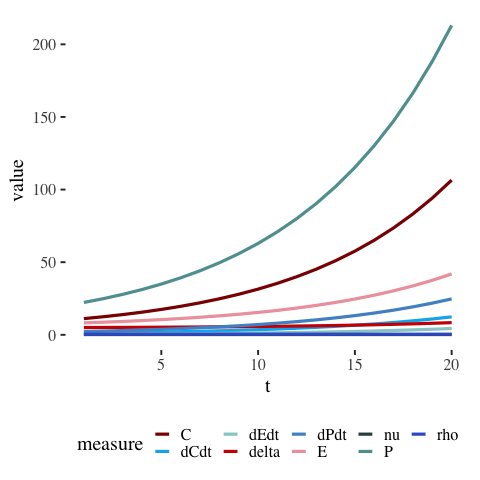

In [10]:
%%R -i df
plot.data <- df %>% gather(measure, value, -t) #%>% 
    #mutate(category = ifelse(measure %in% c('E', 'C', 'P'), 'box', 
                             #ifelse(measure %in% c('dEdt', 'dCdt', 'dPdt'), 'changes', 'parameters')))
ggplot(plot.data, aes(x = t, y = value, color = measure)) + theme_tufte(base_size = 20) + 
    geom_line(size = 1.5) + 
    #facet_wrap(~ category) +
    scale_color_manual(values = palette_ordered) +
    theme(legend.position = 'bottom')

#### Carrying Capacity
Each economy has a carrying capacity, $K$, which is a function of population, $N$.  
$K_C = \alpha N$ and $K_P = \beta N$.
These are upper limits on the sizes of $C$ and $P$, and $\beta > \alpha > 1.$

#### Parameter Updates
The import replacement rate parameter, $\rho$, is updated according to a logistic function
\begin{equation}
\rho = \frac{\rho_{max}}{1 + e^{(\delta_{mid} - \delta)}}
\end{equation}
where 
$\rho_{max} < 1$ and 
\begin{equation}
\delta_{mid} = \frac{\rho_{max}(K_C + K_P)}{2}.
\end{equation}

$\nu$ modifies the increase in production from a previous time step which represents a material flow in units of $X$. This material flow eventually makes it's way to either consumption or exports, but the increase in activity arising from that material flow leaves behind a residual increase in production, and $0 < \nu < 1.$ Represent as a logistic in $\delta$ like $\rho.$ What would $\nu_{max}$ represent?

\begin{array}{ |l|l|l| } 
\hline
\text{Parameter} & \text{Description} & \text{Range} \\
 \hline
 N & \text{the population of an economic unit} & N > 1 \\ 
 \text{steps} & \text{the number of timesteps to run simulation} & \text{steps} > 1 \\ 
 \alpha & \text{multiplies population to determine } K_P & \alpha > 1 \\ 
 \beta & \text{multiplies population to determine } K_C & \beta > 1 \\ 
 \rho & \text{the percentage of imports, both consumption and production, replaced in a given timestep} & 0 < \rho < \rho_{max} < 1 \\ 
 \nu & \text{the multiplier of new production activity, both intensive and extensive} & 0 < \nu < \nu_{max} < 1 \\ 
 \delta & \text{the diversity of goods and services produced in an economic unit} & \delta > 1 \\ 
 \gamma & \text{multiplies increases in the economy to determine increases in diversity} & 0 < \gamma < 1 \\ 
 \hline
\end{array}